In [89]:
import pandas as pd
import numpy as np
import yaml
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from scipy.fft import fft
from scipy.stats import boxcox
from scipy.special import inv_boxcox
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler, PowerTransformer, RobustScaler
import openpyxl
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score,precision_score, f1_score, mean_squared_error
import optuna
import talib
import json
import pickle
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
import torch
from torch_optimizer import Ranger
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch_optimizer as optim
import torch.optim as op
from IPython.display import display, clear_output
from tqdm import tqdm
import os
import sys
import logging
from torch.optim.lr_scheduler import LambdaLR
from torch.optim.lr_scheduler import CyclicLR
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import torch.nn.init as init
from torch.utils.data import Subset
from plotly.subplots import make_subplots
from scipy.stats.mstats import winsorize


In [4]:
print(torch.backends.mps.is_available())

True


In [5]:
def load_yaml(file):
    import yaml
    with open(file, 'r') as f:
        config = yaml.safe_load(f)
    return config

In [6]:
config = load_yaml('../config_vtrans.yaml')

In [100]:
log_dir = "logs"
os.makedirs(log_dir, exist_ok=True)
log_file = "logstraining_logs_vtran12.txt"
log_file_path = os.path.join(log_dir, log_file)
logging.basicConfig(
    filename=log_file_path,
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S"
)

logging.info("Logging started")

In [8]:
all_trading_data_dfs = []
sheet_names = ['5minData11-6-2014', '5minData12-17-2019']
for sheet in sheet_names:
    temp_df = pd.read_excel(config['all_data_excel_path'], sheet_name=sheet)
    all_trading_data_dfs.append(temp_df)
all_trading_data = pd.concat(all_trading_data_dfs, ignore_index=True)

# Load 5 min data
all_trading_data['Date'] = pd.to_datetime(all_trading_data['Date'])

In [9]:
##### Set the Date Start and End for the filtering of trading data
train_start_date = pd.to_datetime('2023-01-01')
train_end_date = pd.to_datetime('2023-05-31')
trading_data_raw = all_trading_data[(all_trading_data['Date'] >= train_start_date) & (all_trading_data['Date'] <= train_end_date)]
trading_data_raw = trading_data_raw.reset_index(drop=True)
trading_data_raw.drop(columns=['Symbol'], inplace=True)
trading_data_raw.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7956 entries, 0 to 7955
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    7956 non-null   datetime64[ns]
 1   Open    7956 non-null   float64       
 2   High    7956 non-null   float64       
 3   Low     7956 non-null   float64       
 4   Close   7956 non-null   float64       
 5   Volume  7956 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 373.1 KB


In [10]:
#### Setting some global variables
n_bars = config['n_past']
m_bars = config['m_future']
fourier_lookback_window = config['fourier_lookback_window']
fourier_n_components = config['fourier_n_components']

In [124]:
def calculate_bollinger_bands(data, window_size, num_std_dev):
    rolling_mean = data['Close'].rolling(window=window_size).mean()
    rolling_std = data['Close'].rolling(window=window_size).std()
    data['BOLLBU'] = rolling_mean + (rolling_std * num_std_dev)
    data['BOLLBM'] = rolling_mean
    data['BOLLBL'] = rolling_mean - (rolling_std * num_std_dev)
    
    return data

def calculate_donchn_bands(data, window_size):
    data['DONCH_U'] = data['High'].rolling(window=window_size).max()
    data['DONCH_L'] = data['Low'].rolling(window=window_size).min()
    
    return data
    
def calculate_tchr(data):
    period = config['tchr_period']
    retracement = config['tchr_retracement']
    adj = config['tchr_adj']
    range = config['tchr_range']

    if range == 'highlow':
        data['TCHR_U'] = talib.MAX(data['High'], timeperiod=period) + adj
        data['TCHR_L'] = talib.MIN(data['Low'], timeperiod=period) - adj
    elif range == 'close':
        data['TCHR_U'] = talib.MAX(data['Close'], timeperiod=period) + adj
        data['TCHR_L'] = talib.MIN(data['Close'], timeperiod=period) - adj
    
    #calculate retracement
    if retracement == "long":
        data['TCHR'] = (data['Close'] - data['TCHR_L']) / (data['TCHR_U'] - data['TCHR_L'])
    elif retracement == "short":
        data['TCHR'] = (data['TCHR_U'] - data['Close']) / (data['TCHR_U'] - data['TCHR_L'])
    
    return data
    
def calculate_adwm(data):
    period = config['adwm_period']
    data['Previous_Close']= data['Close'].shift(1)
    data['TRH'] = data[['High', 'Previous_Close']].max(axis=1)
    data['TRL'] = data[['Low', 'Previous_Close']].min(axis=1)

    data['ADWM_AD'] = 0.0
    data.loc[data['Close'] > data['Previous_Close'], 'ADWM_AD'] = (data['Close'] - data['TRL'])
    data.loc[data['Close'] < data['Previous_Close'], 'ADWM_AD'] = (data['Close'] - data['TRH'])

    data['ADWM'] = data['ADWM_AD']

    data['ADWMMA'] = data['ADWM'].rolling(window=period).mean()

    return data

def calculate_si(row, prev_row, limit):
    if pd.isna(prev_row['Close']):
        return 0
    c = row['Close']
    c_prev = prev_row['Close']
    o = row['Open']
    o_prev = prev_row['Open']
    return (50 * ((c - c_prev) + (0.5 * (c - o)) + (0.25 * (c_prev - o_prev))) / limit)

def calculate_WASI(data):
    wasi_limit = config['wasi_limit']
    data['SI'] = data.apply(lambda row: calculate_si(row, data.shift(1).loc[row.name], wasi_limit), axis=1)
    data['WASI'] = data['SI']
    return data

def calculate_ATR(data):
    atr_period = config['atr_period']
    atr_ma = config['atr_ma']
    data['ATR'] = talib.ATR(data['High'], data['Low'], data['Close'], timeperiod=atr_period)
    data['ADJATR'] = talib.SMA(data['ATR'], timeperiod=atr_ma)
    return data


def compute_volatility_momentum(df, price_col='Close', vol_window=14, mom_window=10):
    """
    Computes rolling volatility and momentum for a given price column.

    Parameters:
        df (pd.DataFrame): DataFrame containing historical price data.
        price_col (str): Column name of the closing price.
        vol_window (int): Window size for rolling volatility calculation.
        mom_window (int): Window size for momentum calculation.

    Returns:
        pd.DataFrame: DataFrame with added 'Volatility' and 'Momentum' features.
    """

    # Ensure price column exists
    if price_col not in df.columns:
        raise ValueError(f"Column '{price_col}' not found in DataFrame")

    # 🔹 Compute Log Returns (for better volatility calculation)
    df['Log_Returns'] = np.log(df[price_col] / df[price_col].shift(1))

    # 🔹 Compute Rolling Volatility (Standard Deviation of Log Returns)
    df['Volatility'] = df['Log_Returns'].rolling(window=vol_window).std()

    # 🔹 Compute Momentum (Rate of Change in Price)
    df['Momentum'] = df[price_col].pct_change(periods=mom_window) * 100

    # 🔹 Drop NaN values from rolling computations
    #df.dropna(inplace=True)

    return df


def compute_fourier_df(value_series, n_components=10):
    fft_result = np.fft.fft(value_series)
    real = fft_result.real[:n_components]
    imag = fft_result.imag[:n_components]
    mag = np.abs(fft_result)[:n_components]

    return real, imag, mag

def get_fourier_columns():
    return [f'fourier_real_{j+2}' for j in range(fourier_n_components-1)] + [f'fourier_imag_{j+2}' for j in range(fourier_n_components-1)] + [f'fourier_mag_{j+2}' for j in range(fourier_n_components-1)]   
    

In [126]:
def add_new_features_df(data):
    fourier_lookback_window = config['fourier_lookback_window']
    fourier_n_components = config['fourier_n_components']

    #data['Date'] = pd.to_datetime(data['Date'])
    #print(f"bolband period : {config['bolband_period']}")
    bolband_period = config['bolband_period']
    bolband_width = config['bolband_width']
    upper, middle, lower = talib.BBANDS(data['Close'], timeperiod=bolband_period, nbdevup=bolband_width, nbdevdn=bolband_width, matype=0)
    data['BOLLBU'] = upper
    data['BOLLBM'] = middle
    data['BOLLBL'] = lower
    #data = calculate_bollinger_bands(data, int(config['bolband_period']), int(config['bolband_width']))

    # Calculate DONCHN Bands
    donchn_period = config['donchn_period']
    data['DONUP'] = talib.MAX(data['High'], timeperiod=donchn_period)

    data['DONLOW'] = talib.MIN(data['Low'], timeperiod=donchn_period)

    data['DONMID'] = (data['DONLOW'] + data['DONUP']) / 2

    data['MA20'] = talib.SMA(data['Close'], timeperiod=20)

    data['MA50'] = talib.SMA(data['Close'], timeperiod=50)

    data['MA100'] = talib.SMA(data['Close'], timeperiod=100)

    data['EMA20'] = talib.EMA(data['Close'], timeperiod=20)

    # Calculate the pivot points
    data['PVPT'] = (data['High'] + data['Low'] + data['Close']) / 3
    data['PVPTR1'] = (2 * data['PVPT']) - data['Low']

    data['PVPTR2'] = data['PVPT'] + data['High'] - data['Low']

    data['PVPTR3'] = data['High'] + 2 * (data['PVPT'] - data['Low'])

    data['PVPTS1'] = (2 * data['PVPT']) - data['High']

    data['PVPTS2'] = data['PVPT'] - (data['High'] - data['Low'])

    data['PVPTS3'] = data['Low'] - 2 * (data['High'] - data['PVPT'])

    data = calculate_tchr(data)

    data = calculate_adwm(data)

    data = calculate_WASI(data)

    volume_ma_period = config['volume_ma_period']

    data['VOLMA'] = talib.SMA(data['Volume'], timeperiod=volume_ma_period)

    data = calculate_ATR(data)

    data['DayofWeek'] = data['Date'].dt.dayofweek

    data['DayofWeek'] = data['DayofWeek'].astype('category')

    data = compute_volatility_momentum(data, price_col='Close', vol_window=config['volatility_period'], mom_window=config['momentum_period'])

    # Add fourier columns to the df
    for i in range(fourier_n_components):
        data[f'fourier_real_{i+1}'] = np.nan
        data[f'fourier_imag_{i+1}'] = np.nan
        data[f'fourier_mag_{i+1}'] = np.nan

    features = []
    epsilon = 1e-5
    print(f"fourier window - 1 : {fourier_lookback_window - 1}")
    for i in range(len(data)):
        if i >= fourier_lookback_window - 1:
            #print("entered point 1")
            close_window = data['Close'].iloc[i - fourier_lookback_window + 1: i + 1].values
            real, imag, mag = compute_fourier_df(close_window, n_components=fourier_n_components)

            for j in range(fourier_n_components):
                data.iloc[i, data.columns.get_loc(f'fourier_real_{j+1}')] = real[j]
                data.iloc[i, data.columns.get_loc(f'fourier_imag_{j+1}')] = imag[j]
                data.iloc[i, data.columns.get_loc(f'fourier_mag_{j+1}')] = mag[j]
                #print(data.loc[i, 'Date'])
    


    # Add the time of day feature to the trading data

    # Define max time of day in minutes
    MAX_TIME_MINUTES = 1440
    data['Minutes_Passed'] = (data['Date'].dt.hour* 60) + data['Date'].dt.minute
    data['TimeOfDay_Group'] = (data['Minutes_Passed'] // 5).astype('int')
    data['Sine_TimeOfDay'] = np.sin(2 * np.pi * data['TimeOfDay_Group'] / MAX_TIME_MINUTES)
    data['Cosine_TimeOfDay'] = np.cos(2 * np.pi * data['TimeOfDay_Group'] / MAX_TIME_MINUTES)
    data['Take_Profit_Level'] = (data['Close'] * config['atr_multiplier'] * data['ADJATR'])
    data['time_delta'] = data['Date'].diff().dt.total_seconds()
    data['time_delta'].fillna(data['time_delta'].median(), inplace=True)
    #print("Feature df info : ")
    #print(data.info())

    #print(f"Last row after adding features : ")
    #print(data.tail())
    return data


#### Adding additional features

In [13]:
trading_data_with_features = add_new_features_df(trading_data_raw.copy())
trading_data_with_features = trading_data_with_features.dropna()
trading_data_with_features.reset_index(drop=True, inplace=True)

number of na s : 0


/var/folders/ns/6tgyd_dx5lq_3chvzvfdm1sr0000gp/T/ipykernel_42242/977004311.py:97: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['time_delta'].fillna(data['time_delta'].median(), inplace=True)


In [14]:
pd.set_option("display.max_columns", None)  # Show all columns
pd.set_option("display.max_rows", None)  # Show all rows
trading_data_with_features.describe().T

,count,mean,min,25%,50%,75%,max,std
Date,7758,2023-03-19 09:24:45.034802688,2023-01-05 13:00:00,2023-02-10 12:06:15,2023-03-20 11:12:30,2023-04-25 10:18:45,2023-05-30 15:55:00,NaN
Open,7758.0,404.553225,378.915,397.45425,406.73,411.753775,422.41,8.992144
High,7758.0,404.816508,379.22,397.7025,406.95115,411.94,422.58,8.945511
Low,7758.0,404.29264,378.915,397.20125,406.51,411.52165,421.91,9.031171
Close,7758.0,404.559044,378.92,397.45125,406.743,411.75,422.4,8.990214
Volume,7758.0,786766.772622,136615.0,418575.0,597977.5,884065.25,14680996.0,778337.655097
BOLLBU,7758.0,405.772607,380.181065,398.743643,407.685584,412.704737,422.335445,8.835232
BOLLBM,7758.0,404.509381,379.6099,397.417109,406.746798,411.712063,421.132395,8.982962
BOLLBL,7758.0,403.246155,377.780783,396.0795,405.546326,410.751789,420.184965,9.209924
DONUP,7758.0,405.809818,380.45,398.7,407.695,412.78,422.58,8.802965


In [15]:
def transform_features(df):
    close_diff_features = config['Close_Diff_Features'].split(',')
    df[close_diff_features] = df[close_diff_features].sub(df['Close'], axis=0)
    return df


In [16]:
trading_data_transformed = transform_features(trading_data_with_features.copy())

In [17]:
def get_all_training_features():
    training_features = config['training_features'].split(',')
    fourier_cols = get_fourier_columns()
    return training_features + fourier_cols

In [18]:
def get_target_scaler(df, n, target_col='Close_Diff'):
    df = df.copy()
    modified_close = []

    for i in range(0, len(df) , n):
        segment = df.iloc[i : i+n].copy()

        if len(segment) == 0:
            continue
        first_value = segment[target_col].iloc[0]
        segment[target_col] = segment[target_col] - first_value
        modified_close.extend(segment[target_col].values)

    modified_close = np.array(modified_close).reshape(-1, 1)

    target_scaler = RobustScaler()
    scaled_close = target_scaler.fit_transform(modified_close)

    return target_scaler

#### Creating dataframe for fitting scaler to be later used for scaling all the data for training

In [19]:
def normalize_timegaps(df, time_gap_threshold=300):
    df = df.copy()
    features = ['Open', 'High', 'Low', 'Close']
    df['time_delta'] = df['Date'].diff().dt.total_seconds()
    df['time_delta'] = df['time_delta'].fillna(df['time_delta'].median())
    df['time_gap_flag'] = df['time_delta'] > time_gap_threshold
    gap_indices = df.index[df['time_gap_flag']].tolist()
    for p in gap_indices:
        if p > 0: # ensure p-1 exist
            jump_value = df.loc[p, 'Close'] - df.loc[p-1, 'Close']
            df.loc[:p-1, features] += jump_value
    return df

In [20]:
trading_data_time_normalized = normalize_timegaps(trading_data_raw)

In [21]:
toplot_df = trading_data_time_normalized

fig = make_subplots(rows=2, cols=1, shared_xaxes=True, 
                    vertical_spacing=0.1,
                    subplot_titles=("CandleStick Chart Norm", "CandleStick Chart"))
fig.add_trace(
    go.Candlestick(
        x=toplot_df['Date'], 
        open=toplot_df['Open'], 
        high=toplot_df['High'], 
        low=toplot_df['Low'], 
        close=toplot_df['Close'],
        name='OHLC Norm'
        ), row=1, col=1
)

fig.add_trace(
    go.Candlestick(
        x=trading_data_raw['Date'], 
        open=trading_data_raw['Open'], 
        high=trading_data_raw['High'], 
        low=trading_data_raw['Low'], 
        close=trading_data_raw['Close'],
        name='OHLC'
        ), row=2,col=1
)

fig.update_layout(
    title='CandleStick chart of time normalized',
    xaxis=dict(type="date", 
               rangebreaks=[
                   dict(bounds=["sat", "mon"]),
                   dict(bounds=[16,9.5], pattern='hour')
               ]              
            ),
    xaxis_rangeslider_visible=False,
    height=600,
    hovermode='x unified'
)



fig.update_xaxes(matches='x')

fig.show()

#### Doing some EDA on the Close Diff to find optimal category splitting


In [22]:
trading_data_Close_EDA = trading_data_time_normalized.copy()
trading_data_Close_EDA['Close_Diff'] = trading_data_Close_EDA['Close'].diff().fillna(0)

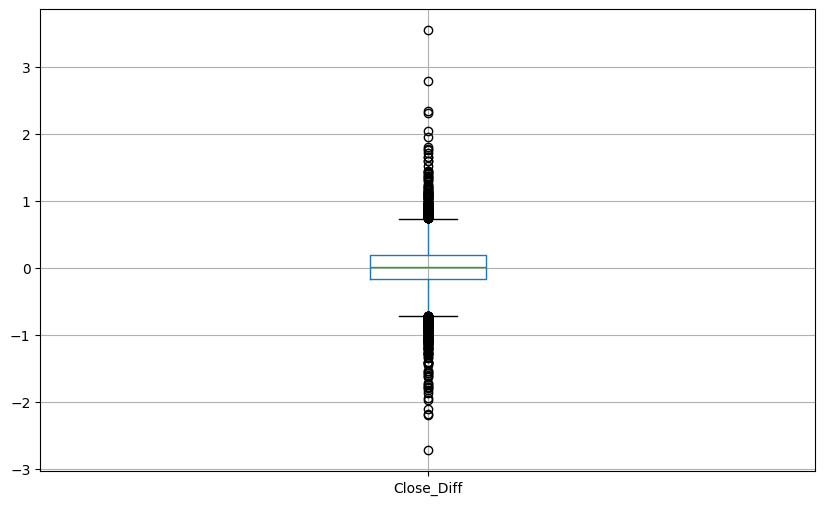

In [23]:
#trading_data_Close_EDA['Close_Diff'].hist(bins=100, figsize=(10, 6))
trading_data_Close_EDA[['Close_Diff']].boxplot(figsize=(10, 6))
plt.show()

In [24]:
trading_data_Close_EDA[['Close_Diff']].describe()

,Close_Diff
count,7956.000000
mean,0.005510
std,0.355403
min,-2.717200
25%,-0.170925
50%,0.009950
75%,0.189900
max,3.550000


In [25]:
def count_outliers_iqr(df, feature):
    """
    Count the number of outliers in a feature using the IQR method.
    """
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1

    # Define outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    print(f"Lower bound: {lower_bound} and Upper bound: {upper_bound}")
    # Count outliers
    low_outliers = df[(df[feature] < lower_bound)]
    high_outliers = df[(df[feature] > upper_bound)]
    
    print(f"Feature: {feature}")
    print(f"Number of Low outliers: {len(low_outliers)}")
    print(f"Number of High outliers: {len(high_outliers)}")

In [26]:
count_outliers_iqr(trading_data_Close_EDA, 'Close_Diff')
print(f"Total number of rows : {len(trading_data_Close_EDA)}")

Lower bound: -0.712162500000062 and Upper bound: 0.7311375000000737
Feature: Close_Diff
Number of Low outliers: 208
Number of High outliers: 185
Total number of rows : 7956


In [27]:
unit_price = 0.1
# 🔹 Create bins (round `close_diff` to the nearest 0.1 step)
trading_data_Close_EDA["close_bins"] = np.round(trading_data_Close_EDA["Close_Diff"] / unit_price) * unit_price  # Converts to nearest bin
trading_data_Close_EDA['close_bins'] = trading_data_Close_EDA['close_bins'].clip(lower=-0.8, upper=0.8)

trading_data_Close_EDA['close_bins'] = (trading_data_Close_EDA['close_bins'] / unit_price).astype(int)

#convert to categorical type
trading_data_Close_EDA['close_bins'] = trading_data_Close_EDA['close_bins'].astype('category')

# 🔹 Count occurrences in each bin
bin_counts = trading_data_Close_EDA["close_bins"].value_counts(ascending=False)

# 🔹 Print top bin counts
print("Top Bin Counts:")
print(bin_counts)

Top Bin Counts:
close_bins
 0    1206
 1    1159
-1    1042
 2     874
-2     767
 3     558
-3     500
 4     339
-4     305
 5     212
-5     202
-8     178
 8     178
-6     141
 6     130
-7      89
 7      76
Name: count, dtype: int64


### Adding all features

In [28]:
trading_data_with_features = add_new_features_df(trading_data_Close_EDA.copy())

number of na s : 0


/var/folders/ns/6tgyd_dx5lq_3chvzvfdm1sr0000gp/T/ipykernel_42242/977004311.py:97: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





###  Transform Features that have to be differenced from Close

In [29]:
trading_data_transformed = transform_features(trading_data_with_features.copy())

In [30]:
all_training_features = get_all_training_features()

### Do Robust scaling on all training features

In [31]:
trading_data_scaled = trading_data_transformed.copy()
rscaler = RobustScaler()
trading_data_scaled[all_training_features] = rscaler.fit_transform(trading_data_scaled[all_training_features])

### Use Clipping (Winsorization) to Limit Extreme Values

In [32]:
def winsor_features(df, features, lower=5, upper=95):
    df = df.copy()
    lower_limit = lower / 100
    upper_limit = (100 - upper) / 100
    for feature in features:
        df[feature] = winsorize(df[feature], limits=(lower_limit, upper_limit))

    return df

In [33]:
### Set lower limit and upper limit for winsor
lower_limit_winsor = 5
upper_limit_Winsor = 95
### Apply the winsorization for all training features
trading_data_scaled = winsor_features(trading_data_scaled, all_training_features, lower=lower_limit_winsor, upper=upper_limit_Winsor)


In [34]:
### Check box plot for all training features
plt.figure(figsize=(20, 10))
sns.boxplot(data=trading_data_scaled[all_training_features])
plt.xticks(rotation=45)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50],
 [Text(0, 0, 'BOLLBU'),
  Text(1, 0, 'BOLLBM'),
  Text(2, 0, 'BOLLBL'),
  Text(3, 0, 'DONUP'),
  Text(4, 0, 'DONMID'),
  Text(5, 0, 'DONLOW'),
  Text(6, 0, 'MA20'),
  Text(7, 0, 'MA50'),
  Text(8, 0, 'MA100'),
  Text(9, 0, 'EMA20'),
  Text(10, 0, 'PVPTR1'),
  Text(11, 0, 'PVPTR2'),
  Text(12, 0, 'PVPTR3'),
  Text(13, 0, 'PVPTS1'),
  Text(14, 0, 'PVPTS2'),
  Text(15, 0, 'PVPTS3'),
  Text(16, 0, 'Sine_TimeOfDay'),
  Text(17, 0, 'Cosine_TimeOfDay'),
  Text(18, 0, 'ADWMMA'),
  Text(19, 0, 'TCHR'),
  Text(20, 0, 'VOLMA'),
  Text(21, 0, 'ADJATR'),
  Text(22, 0, 'Volatility'),
  Text(23, 0, 'Momentum'),
  Text(24, 0, 'fourier_real_2'),
  Text(25, 0, 'fourier_real_3'),
  Text(26, 0, 'fourier_real_4'),


In [139]:
def one_hot_encode(indices, num_classes):
    """
    One-hot encode the given indices into a one-hot matrix.
    Args:
    - indices: NumPy array of shape [seq_length, forecast_horizon] containing class indices.
    - num_classes: Total number of classes.
    
    Returns:
    - One-hot encoded array of shape [seq_length, forecast_horizon, num_classes].
    """
    one_hot = np.zeros((indices.shape[0], indices.shape[1], num_classes))
    for i in range(indices.shape[0]):  # Loop through sequence_length
        for j in range(indices.shape[1]):  # Loop through forecast_horizon
            one_hot[i, j, indices[i, j]] = 1  # Set one-hot encoding
    return one_hot

#### Custom Dataset for Multistep Transformer

In [140]:
class FinancialDataset(Dataset):
    def __init__(self, df, features, target_col, sequence_length, forecast_horizon, unit_price=0.1, target_bin_max=8):
        """
        Args:
        - df: Preprocessed and scaled DataFrame
        - features: List of feature column names
        - target_col: Name of the target column (e.g., 'Close')
        - sequence_length: Number of past bars to use as input
        - forecast_horizon: Number of future bars to predict
        - unit_price: Unit price for Close price encoding
        """
        self.df = df.copy()
        self.features = features
        self.target_col = target_col
        self.sequence_length = sequence_length
        self.forecast_horizon = forecast_horizon
        self.unit_price = unit_price
        self.target_bin_max = target_bin_max

        # Automatically determine number of output classes
        self.output_dim = (target_bin_max * 2) + 1  # Include zero

        # Convert Close price differences into categorical classes
        self.df['close_diff_category'] = ((self.df[self.target_col].diff().fillna(0)) / self.unit_price).astype(int)
        self.df['close_diff_category'] = self.df['close_diff_category'].clip(lower=-target_bin_max, upper=target_bin_max)
        self.df['close_diff_category'] = self.df['close_diff_category'].astype('category')

        # Compute class distribution
        self.class_counts = self.df['close_diff_category'].value_counts().to_dict()
        print(f"Class counts : {self.class_counts}")
        self.total_samples = len(self.df)
        
        # Compute class weights (Inverse frequency)
        self.class_weights = {cls: self.total_samples / count for cls, count in self.class_counts.items()}
        print(f"Class weights : {self.class_weights}")
        # Create index list for weighted sampling
        self.index_list = self._balance_classes()

    def _balance_classes(self):
        """
        Creates an index list with class-balanced sampling.
        Returns a list of indices where underrepresented classes are oversampled.
        """
        weighted_indices = []
        for cls, weight in self.class_weights.items():
            class_indices = self.df[self.df['close_diff_category'] == cls].index.tolist()

            valid_indices = []
            for idx in class_indices:
                shift = np.random.randint(1, self.forecast_horizon + 1)  # Ensure enough future bars
                full_seq_length = self.sequence_length + shift

                if (idx - full_seq_length) > 0 and (self.forecast_horizon - shift + idx) < len(self.df):
                    valid_indices.append(idx - full_seq_length)

            num_samples = int(len(class_indices) * weight)  # Oversample underrepresented classes
            weighted_indices.extend(np.random.choice(valid_indices, num_samples, replace=True))
        return weighted_indices

    def __len__(self):
        return len(self.index_list) - self.sequence_length - self.forecast_horizon

    def __getitem__(self, idx):
        """
        Fetches one sequence ensuring class-balanced batches.
        """
        s = self.index_list[idx]  # Use balanced index
        #print(f"s : {s} and full df length : {len(self.df)}")
        full_seq = self.df.iloc[s:s + self.sequence_length + self.forecast_horizon].copy()

        # Prepare input (X) and target (y)
        past_seq = full_seq.iloc[:self.sequence_length]
        #future_prices = full_seq.iloc[self.sequence_length:]['close_diff_category']
        future_prices = []
        for i in range(self.sequence_length):
            future_prices.append(full_seq.iloc[i + 1 : i + 1 + self.forecast_horizon]['close_diff_category'].values)

        future_prices = np.array(future_prices).reshape(self.sequence_length, self.forecast_horizon)
        #if future_prices.dtype.name == 'category':
        #    future_prices = future_prices.cat.codes
            #print(f"future prices : {future_prices}")

        future_prices_onehot = one_hot_encode(future_prices, self.output_dim)
        prev_closes = full_seq.iloc[:self.sequence_length]['close_diff_category']


        # Convert to tensors
        X = torch.tensor(past_seq[self.features].values, dtype=torch.float32)
        y = torch.tensor(future_prices_onehot, dtype=torch.float32)
        prev_closes = torch.tensor(prev_closes.cat.codes.values, dtype=torch.long).view(self.sequence_length, 1)

        # Decoder input: only previous Close prices (no time deltas)
        decoder_input = prev_closes

        return X, y, decoder_input


In [141]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model=128, num_heads=4, num_layers=3, ff_dim=256, output_dim=17, forecast_horizon=12, dropout=0.1):
        """
        Args:
        - input_dim: Number of input features
        - d_model: Transformer embedding size
        - num_heads: Number of attention heads
        - num_layers: Number of Transformer layers
        - ff_dim: Feedforward hidden layer size
        - output_dim: Number of target categories
        - dropout: Dropout rate
        """
        super(TransformerModel, self).__init__()

        self.forecast_horizon = forecast_horizon
        # Encoder Embedding (No ReLU, Linear Projection)
        self.encoder_embedding = nn.Linear(input_dim, d_model)  # Shape: (batch_size, seq_len, input_dim) -> (batch_size, seq_len, d_model)

        # Decoder Embedding (Now with ReLU)
        self.decoder_embedding = nn.Sequential(
            nn.Linear(1, d_model),  # Shape: (batch_size, seq_len, 1) -> (batch_size, seq_len, d_model)
            nn.ReLU(),
            nn.LayerNorm(d_model)
        )

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=num_heads, dim_feedforward=ff_dim,
                                                   dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Transformer Decoder
        decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=num_heads, dim_feedforward=ff_dim,
                                                   dropout=dropout, batch_first=True)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)

        # Fully connected output layer for classification
        self.fc_out = nn.Linear(d_model, output_dim * forecast_horizon)  # Shape: (batch_size, seq_len, d_model) -> (batch_size, seq_len, output_dim * forecast_horizon)

        # Positional Encoding (Learnable)
        self.positional_encoding = nn.Parameter(torch.randn(1, 500, d_model) * 0.02)  # Shape: (1, max_seq_len, d_model)
        self.output_dim = output_dim

    def forward(self, encoder_input, decoder_input):
        """
        Args:
        - encoder_input: (batch_size, seq_len, input_dim)
        - decoder_input: (batch_size, seq_len, 1) [previous Close price categories]
        """

        batch_size, seq_len, _ = encoder_input.shape
        # Encode numerical input features (No ReLU here)
        encoder_input = self.encoder_embedding(encoder_input)  # Shape: (batch_size, seq_len, input_dim) -> (batch_size, seq_len, d_model)
        encoder_input += self.positional_encoding[:, :encoder_input.size(1), :]  # Positional Encoding added
        encoder_output = self.transformer_encoder(encoder_input)  # Shape: (batch_size, seq_len, d_model) -> (batch_size, seq_len, d_model)

        # Encode previous Close price categories (With ReLU)
        decoder_hidden = self.decoder_embedding(decoder_input)  # Shape: (batch_size, seq_len, 1) -> (batch_size, seq_len, d_model)
        decoder_hidden += self.positional_encoding[:, :decoder_hidden.size(1), :]  # Positional Encoding added
        decoder_hidden = self.transformer_decoder(decoder_hidden, encoder_output)  # Shape: (batch_size, seq_len, d_model) -> (batch_size, seq_len, d_model)

        # Output layer (Classification)
        output = self.fc_out(decoder_hidden)  # Shape: (batch_size, seq_len, d_model) -> (batch_size, seq_len, output_dim)
        output = output.view(batch_size, seq_len, self.forecast_horizon, self.output_dim)  # Shape: (batch_size, seq_len, output_dim * forecast_horizon) -> (batch_size, seq_len, forecast_horizon, output_dim)
        
        return output  # Shape: (batch_size, seq_len, forecast_horizon, output_dim)

1️⃣ General Formula for Choosing d_model
✔ Formula:
python
Copy
Edit
d_model ≈ 4 * sqrt(n_features)
Why?

Too small (d_model < n_features) → Model may not learn useful representations.
Too large (d_model > 10 * n_features) → Increases computation and risk of overfitting.
📌 2️⃣ Recommended Values Based on n_features
n_features	Recommended d_model
10-20	d_model = 32 - 64
30-50	d_model = 64 - 128
50-100	d_model = 128 - 256
100-200	d_model = 256 - 512
200+	d_model = 512 - 1024
✅ For small datasets (n_features < 50), use d_model = 64 - 128.



🚀 1️⃣ General Formula for Choosing hidden_dim
A good rule of thumb:

python
Copy
Edit
hidden_dim ≈ 4 * d_model
✔ Recommended hidden_dim for d_model = 256
python
Copy
Edit
hidden_dim = 4 * 256 = 1024
✅ hidden_dim should be around 1024 when d_model = 256.
✅ Smaller hidden dimensions (e.g., 512) may reduce model capacity but save memory.
✅ Larger hidden dimensions (e.g., 2048) increase expressiveness but require more computation.


🚀 1️⃣ General Formula for Choosing n_heads
The number of heads should evenly divide d_model:

python
Copy
Edit
n_heads = d_model // 32
Since d_model = 256, we get:

python
Copy
Edit
n_heads = 256 // 32 = 8
✅ Recommended n_heads = 8 for d_model = 256.

📌 2️⃣ Recommended n_heads Based on d_model
d_model	Recommended n_heads
64	2
128	4
256	8
512	8 or 16
1024	16 or 32
🔹 n_heads should evenly divide d_model to ensure efficient computation.
🔹 A higher n_heads improves expressiveness but increases computation cost.

In [165]:
num_epochs = 20
d_model = 256
num_layers=4
dropout=0.1
nhead=8
learning_rate=0.01
ffn_hidden_dim = 1024
num_batches = 256
loss_beta = 8
start_epoch = 0

#### Set this new_training to True if to start a new training.
#### Set the new_training to False to continue from the epoch specified in start_epoch

In [166]:
new_training = True

### Get the Device to do training

In [167]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


#### Define th Dataset and  DataLoader

In [168]:
# 🔥 Create Dataset & DataLoader
dataset = FinancialDataset(trading_data_scaled, features=all_training_features, target_col='Close', sequence_length=n_bars, forecast_horizon=m_bars)
dataloader = DataLoader(dataset, batch_size=num_batches, shuffle=False)

Class counts : {0: 2329, 1: 1039, -1: 925, 2: 675, -2: 596, 3: 442, -3: 396, 4: 260, -4: 242, -5: 171, 5: 166, -8: 149, 8: 133, -6: 103, 6: 103, 7: 66, -7: 62}
Class weights : {0: 3.373550880206097, 1: 7.562078922040423, -1: 8.494054054054054, 2: 11.64, -2: 13.18288590604027, 3: 17.77601809954751, -3: 19.84090909090909, 4: 30.21923076923077, -4: 32.46694214876033, -5: 45.94736842105263, 5: 47.33132530120482, -8: 52.73154362416108, 8: 59.07518796992481, -6: 76.28155339805825, 6: 76.28155339805825, 7: 119.04545454545455, -7: 126.7258064516129}


#### Define the model

In [169]:
input_dim = len(all_training_features)
output_dim = dataset.output_dim
model = TransformerModel(input_dim=input_dim, d_model=d_model, num_heads=nhead, num_layers=num_layers, ff_dim=ffn_hidden_dim, output_dim=output_dim, forecast_horizon=m_bars, dropout=dropout)
model.to(device)

TransformerModel(
  (encoder_embedding): Linear(in_features=51, out_features=256, bias=True)
  (decoder_embedding): Sequential(
    (0): Linear(in_features=1, out_features=256, bias=True)
    (1): ReLU()
    (2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=1024, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=1024, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (transfo

### Define Loss and Optimizer

betas=(β1, β2)  # Example: betas=(0.9, 0.999)
betas control two things:

β1 (Momentum term) → Controls how much past gradients influence updates.
β2 (Adaptive smoothing term) → Controls how variance in gradients is handled.
🔹 β1 (Momentum: Default 0.9)

A higher β1 (closer to 1) makes training smoother but might react slowly to sudden changes.
A lower β1 (closer to 0.5)` makes training more adaptive but noisier.
🔹 β2 (Gradient Variance: Default 0.999)

Controls how past squared gradients are accumulated to normalize updates.
A higher β2 (~0.999) keeps updates stable but slows down adaptation.
A lower β2 (~0.95) makes updates faster but noisier.
✅ For Transformers, betas=(0.9, 0.999) is usually best.
✅ For Ranger, betas=(0.95, 0.999) works better for more aggressive updates.


#### eps: Numerical Stability Factor
python
Copy
Edit
eps=1e-8  # Default: 1e-8
🔹 Prevents division by zero errors when normalizing gradients.
🔹 Avoids unstable updates when gradients are very small.

✅ For most models, keep eps=1e-8 (default).
✅ For very noisy gradients, increase to eps=1e-6.

#### 3️⃣ weight_decay: L2 Regularization
python
Copy
Edit
weight_decay=1e-3  # Example value
🔹 Adds L2 regularization to prevent overfitting.
🔹 Higher weight_decay (e.g., 1e-2) makes the model weights smaller, reducing overfitting.
🔹 Lower weight_decay (e.g., 1e-5) makes training less restrictive but may overfit.

✅ For Transformers, weight_decay=1e-3 is a good balance.
✅ For smaller datasets, use 1e-4 to prevent overfitting.



In [170]:
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Ranger(model.parameters(), lr=learning_rate, eps=1e-8, weight_decay=1e-3)
#model = VariationalTransformer(input_dim=input_dim, d_model=d_model, nhead=nhead, num_layers=num_layers, dropout=dropout, forecast_horizon=m_bars).to(device)
#model.apply(init_weights)

#### Create a function for initializing Weights

In [171]:
def init_weights(m):
    """Initialize weights for Linear, Transformer, and LayerNorm layers."""
    if isinstance(m, nn.Linear):
        if m.weight is not None and m.weight.dim() >= 2:  # Ensure weight has at least 2D
            init.xavier_uniform_(m.weight)  # Xavier initialization
        if m.bias is not None:
            init.zeros_(m.bias)  # Set bias to zero

    elif isinstance(m, nn.TransformerEncoderLayer) or isinstance(m, nn.TransformerDecoderLayer):
        # Transformer layers contain multiple sublayers (like self-attention)
        for name, param in m.named_parameters():
            if "weight" in name and param.dim() >= 2:  # Ensure weight has at least 2D
                init.xavier_uniform_(param)
            elif "bias" in name:
                init.zeros_(param)

    elif isinstance(m, nn.LayerNorm):
        # LayerNorm weights and biases are 1D tensors
        if m.weight is not None and m.weight.dim() == 1:
            init.ones_(m.weight)  # Set scale to 1
        if m.bias is not None and m.bias.dim() == 1:
            init.zeros_(m.bias)  # Set shift to 0

#### Apply Weight Initialization

In [172]:
model.apply(init_weights)

TransformerModel(
  (encoder_embedding): Linear(in_features=51, out_features=256, bias=True)
  (decoder_embedding): Sequential(
    (0): Linear(in_features=1, out_features=256, bias=True)
    (1): ReLU()
    (2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=1024, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=1024, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (transfo

#### Create a function to find the optimal Learning Rate

In [173]:
def lr_finder(model, dataloader, criterion, min_lr=1e-7, max_lr=1, beta=0.98):
    """
    Implements the Learning Rate Finder to automatically find the best LR.
    
    Args:
    - model: Transformer model
    - dataloader: Training dataloader
    - criterion: Loss function (CrossEntropyLoss for classification)
    - min_lr: Minimum learning rate
    - max_lr: Maximum learning rate
    - beta: Smoothing factor for loss averaging

    Returns:
    - Suggested optimal LR from the LR range test
    """

    model.to(device)
    model.train()

    optimizer = optim.Ranger(model.parameters(), lr=min_lr)
    
    num_batches = len(dataloader)
    lr_mult = (max_lr / min_lr) ** (1 / num_batches)
    lr = min_lr
    optimizer.param_groups[0]['lr'] = lr
    
    avg_loss, best_loss = 0.0, float('inf')
    losses, log_lrs = [], []

    for i, (X_batch, y_batch, decoder_input) in enumerate(dataloader):
        
        X_batch, decoder_input = X_batch.to(device), decoder_input.to(device).float()
        y_batch = y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch, decoder_input)
        #print(f"output shape : {outputs.shape}")
        batch_size, seq_len, forecast_horizon, output_dim = outputs.shape
        outputs = outputs.view(-1, output_dim)
        y_batch = y_batch.view(-1, output_dim)
        y_batch = y_batch.argmax(dim=-1)
        #print(f"output type : {outputs.dtype} and y_batch type : {y_batch.dtype}")
        loss = criterion(outputs, y_batch)
        #loss = criterion(outputs, y_batch)

        avg_loss = beta * avg_loss + (1 - beta) * loss.item()
        smoothed_loss = avg_loss / (1 - beta ** (i + 1))

        if i > 0 and smoothed_loss > 4 * best_loss:
            break  # Stop if loss explodes

        if smoothed_loss < best_loss:
            best_loss = smoothed_loss

        losses.append(smoothed_loss)
        log_lrs.append(lr)

        loss.backward()
        optimizer.step()

        lr *= lr_mult
        optimizer.param_groups[0]['lr'] = lr
        if i % 5 == 0:
            print(f"Batch {i}/{num_batches} | LR: {lr:.6f} | Loss: {smoothed_loss:.4f}")

    # Plot Loss vs Learning Rate
    plt.figure(figsize=(8, 6))
    plt.plot(log_lrs[10:-5], losses[10:-5])
    plt.xscale("log")
    plt.xlabel("Learning Rate (log scale)")
    plt.ylabel("Loss")
    plt.title("Learning Rate Finder")
    plt.show()

    # Suggest the best learning rate: The LR just before the loss starts increasing
    min_loss_idx = losses.index(min(losses))
    optimal_lr = log_lrs[min_loss_idx]
    print(f"Suggested Optimal Learning Rate: {optimal_lr:.6f}")

    return optimal_lr

#### Train to find the optimal Learning Rate

In [174]:
find_optimal_learning_rate = False
if find_optimal_learning_rate:
    optimal_lr = lr_finder(model, dataloader, criterion, min_lr=1e-4, max_lr=1)

In [175]:
optimal_learning_rate = 0.001482

### Going to start actual Training

#### Initialize model and init weights

In [176]:
model = TransformerModel(input_dim=input_dim, d_model=d_model, num_heads=nhead, num_layers=num_layers, ff_dim=ffn_hidden_dim, output_dim=output_dim, forecast_horizon=m_bars, dropout=dropout)
model.to(device)
model.apply(init_weights)

TransformerModel(
  (encoder_embedding): Linear(in_features=51, out_features=256, bias=True)
  (decoder_embedding): Sequential(
    (0): Linear(in_features=1, out_features=256, bias=True)
    (1): ReLU()
    (2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=1024, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=1024, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (transfo

In [177]:
optimizer = optim.Ranger(model.parameters(), lr=optimal_learning_rate)

In [178]:
split_index = int(0.8 * len(dataset))

# Split dataset sequentially into training and validation sets
train_dataset = Subset(dataset, range(0, split_index))
val_dataset = Subset(dataset, range(split_index, len(dataset)))

In [179]:
### Create Dataloaders
train_loader = DataLoader(train_dataset, batch_size=num_batches, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=num_batches, shuffle=False)

In [180]:
checkpoint_dir = "checkpoints_vtrans_encoding"
os.makedirs(checkpoint_dir, exist_ok=True)

In [181]:
def save_checkpoint(epoch, model, optimizer, loss):
    checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch}.pth")
    checkpoint = {
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "loss": loss,
    }
    torch.save(checkpoint, checkpoint_path)
    print(f"Saved checkpoint : {checkpoint_path}")

In [182]:
def load_checkpoint(epoch, model, optimizer=None):
    checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch}.pth")
    if not os.path.exists(checkpoint_path):
        raise FileNotFoundError(f"❌ Checkpoint for epoch {epoch} not found!")
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    if optimizer:
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    epoch = checkpoint["epoch"]
    loss = checkpoint["loss"]
    print(f"Loaded checkpoint from {checkpoint_path} (epoch {epoch})")
    return epoch, model, optimizer, loss

In [183]:
new_training = True
if not new_training:
    print("New training set to false, so loading from checkpoint")
    start_epoch, model, optimizer, loss = load_checkpoint(start_epoch, model, optimizer)
    for param_group in optimizer.param_groups:
        param_group['lr'] = learning_rate

In [184]:
print(f"Starting training from epoch {start_epoch + 1}")

Starting training from epoch 1


In [185]:
for param_group in optimizer.param_groups:
    print(f"Learning rate : {param_group['lr']}")

Learning rate : 0.001482


In [186]:
#for param in model.parameters():
#    print(param.grad)

#### Training Loop

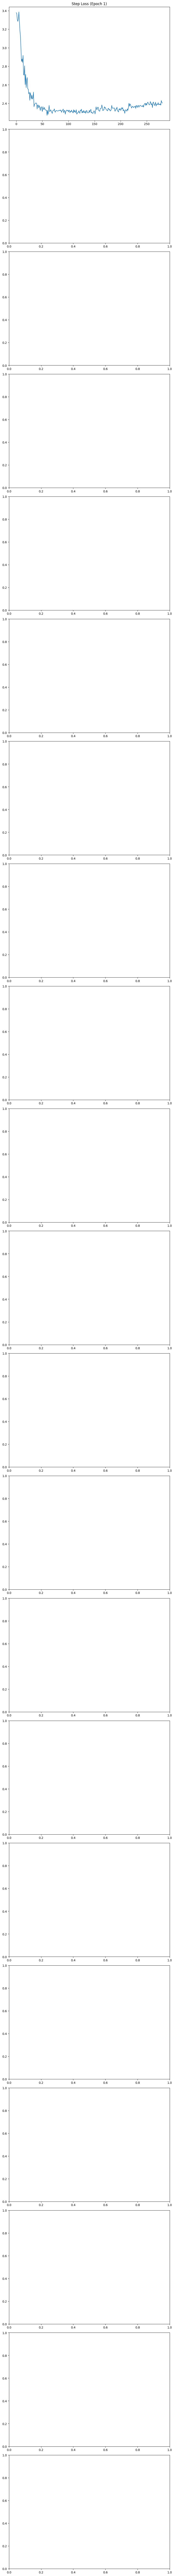

In [ ]:
plt.ion()
fig, axes = plt.subplots(num_epochs - start_epoch + 1,1, figsize=(8, 6 * num_epochs), constrained_layout=True)

train_losses , val_losses = [], []
train_accuracies, val_accuracies = [], []
train_mses, val_mses = [], []


for epoch in range(start_epoch + 1,num_epochs):
    epoch_loss, correct, total, mse_loss = 0.0, 0, 0, 0.0
    loss_values = []
    model.train()
    ax = axes[epoch - start_epoch - 1]
    
    for i, (X_batch, y_batch, decoder_input) in enumerate(train_loader):
        
        X_batch, decoder_input = X_batch.to(device).float(), decoder_input.to(device).float()
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        
        outputs = model(X_batch, decoder_input)
        
        outputs = outputs.view(-1, output_dim)
        y_batch = y_batch.view(-1, output_dim)
        y_batch = y_batch.argmax(dim=-1)

        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        step_loss = loss.item()
        epoch_loss += step_loss
        loss_values.append(step_loss)

        predicted_classes = outputs.argmax(dim=-1)
        actual_classes = y_batch
        correct += (predicted_classes == actual_classes).sum().item()
        total += actual_classes.numel()
        mse_loss += torch.mean((predicted_classes.float() - actual_classes.float()) ** 2).item()

        if i % 10 == 0:
            logging.info(f"Iteration {i}: Loss = {loss.item():.6f}, Accuracy = {100 * correct / total:.2f}%, MSE = {mse_loss / (i + 1):.4f}")

        
        
        #progress_bar.set_postfix({'Step Loss': f'{loss.item():.6f}'})
        ax.clear()
        ax.plot(loss_values, label='Loss')
        ax.set_title(f"Step Loss (Epoch {epoch})")
        
        #plt.draw()
        #plt.pause(0.01)

        #ax.legend()
        clear_output(wait=True)
        display(fig)

    
    ### Store the training metrics
    train_losses.append(epoch_loss / len(train_loader))
    train_accuracies.append(100 * correct / total)
    train_mses.append(mse_loss / len(train_loader))
    avg_epoch_loss = epoch_loss / len(train_loader)
    logging.info(f"Epoch {epoch+1}: Train Loss={train_losses[-1]:.4f}, Train Acc={train_accuracies[-1]:.2f}%, Train MSE={train_mses[-1]:.4f}")
    save_checkpoint(epoch, model, optimizer, avg_epoch_loss)

    ### Testing on the validation set
    model.eval()
    test_loss, correct, total, mse_loss = 0.0, 0, 0, 0.0

    with torch.no_grad():
        for i, (X_batch, y_batch, decoder_input) in enumerate(val_loader):
            X_batch, decoder_input = X_batch.to(device).float(), decoder_input.to(device).float()
            y_batch = y_batch.to(device)

            outputs = model(X_batch, decoder_input)
            outputs = outputs.view(-1, output_dim)
            y_batch = y_batch.view(-1, output_dim)
            y_batch = y_batch.argmax(dim=-1)

            loss = criterion(outputs, y_batch)
            test_loss += loss.item()

            predicted_classes = outputs.argmax(dim=-1)
            actual_classes = y_batch
            correct += (predicted_classes == actual_classes).sum().item()
            total += actual_classes.numel()
            mse_loss += torch.mean((predicted_classes.float() - actual_classes.float()) ** 2).item()

        # Store test metrics
        val_losses.append(test_loss / len(val_loader))
        val_accuracies.append(100 * correct / total)
        val_mses.append(mse_loss / len(val_loader))

        logging.info(f"Epoch {epoch+1}: Val Loss={val_losses[-1]:.4f}, Val Acc={val_accuracies[-1]:.2f}%, Val MSE={val_mses[-1]:.4f}")

print("Training Complete !")
plt.ioff()

In [105]:
bolband_period = config['bolband_period']
donchn_period = config['donchn_period']
max_MA_period = 100
max_EMA_period = 20
tchr_period = config['tchr_period']
adwm_period = config['adwm_period']
atr_period = config['atr_period']
volume_ma_period = config['volume_ma_period']
volatility_period = config['volatility_period']
momentum_period = config['momentum_period']
fourier_lookback_window = config['fourier_lookback_window']
print(f" Fourier window : {fourier_lookback_window}")
max_window = max(bolband_period, 
                 donchn_period, 
                 max_MA_period, 
                 max_EMA_period,
                 tchr_period,
                 adwm_period,
                 atr_period,
                 volume_ma_period, fourier_lookback_window)
print(f"Max window : {max_window}")

 Fourier window : 100
Max window : 100


In [137]:
from matplotlib.pylab import f


def predict_future(df, model, sequence_length, forecast_horizon, feature_scaler, target_bin_max, unit_price):
    model.eval()
    df_predict = df.copy()
    #print(f"df shape at pp 1 : {df_predict.shape}")
    df_predict = normalize_timegaps(df_predict)
    #print(f"df shape at pp 2 : {df_predict.shape}")
    df_features = add_new_features_df(df_predict)
    df_features = df_features.dropna()
    #print(f"df shape at pp 3 : {df_features.shape}")
    df_transformed = transform_features(df_features)
    #print(f"df shape at pp 4 : {df_transformed.shape}")
    

    df_transformed['close_diff_category'] = ((df_transformed['Close'].diff().fillna(0)) / unit_price).astype(int)
    df_transformed['close_diff_category'] = df_transformed['close_diff_category'].clip(lower=-target_bin_max, upper=target_bin_max)
    df_transformed['close_diff_category'] = df_transformed['close_diff_category'].astype('category')

    df_transformed = df_transformed.iloc[-sequence_length:]
    df_transformed.reset_index(drop=True, inplace=True)
    #print(f"df shape at point 1 : {df_transformed.shape}")
    
    all_training_features = get_all_training_features()
    df_transformed[all_training_features] = feature_scaler.transform(df_transformed[all_training_features])
    #print(f"df shape at point 2 : {df_transformed.shape}")
    df_transformed = winsor_features(df_transformed, all_training_features, lower=5, upper=95)
    #print(f"df shape at point 3 : {df_transformed.shape}")
    # X_input Shape: [1, seq_length, feature_dim]
    X_input = torch.tensor(df_transformed[all_training_features].values, dtype=torch.float32).unsqueeze(0).to(device)
    
    
    last_m_closes = df_transformed['close_diff_category'].values.reshape(sequence_length, 1)

    #last_m_closes shape : [1, seq_length, 1]
    last_m_closes_tensor = torch.tensor(last_m_closes, dtype=torch.float32).unsqueeze(0).to(device)
    
    with torch.no_grad():
        outputs = model(X_input, last_m_closes_tensor)
    outputs = outputs.squeeze(0)[-1, :, :]
    print(f"outputs shape : {outputs.shape}")
    
    # predicted cat Shape: [sequence_length, forecast_horizon]
    #predicted_categories = outputs.argmax(dim=-1).squeeze(0).cpu().numpy()
    predicted_categories = outputs
    #print(f"predicted categories : {predicted_categories}")

    return predicted_categories

In [138]:

pred_start_time = pd.to_datetime('2023-03-02 10:20:00')
pred_start_idx = all_trading_data.index[all_trading_data['Date'] >= pred_start_time][0]
pred_before_extend = config['pred_before_extend']
pred_after_extend = config['pred_after_extend']
n_bars = config['n_past']
m_bars = config['m_future']
start_idx = max(0, pred_start_idx - n_bars - max_window - pred_before_extend)
end_idx= min(len(all_trading_data), pred_start_idx + m_bars + pred_after_extend)
trading_data_inference = all_trading_data.loc[start_idx:end_idx].copy()
trading_data_inference.drop(columns=['Symbol'], inplace=True)
# Take the first m_bars rows of trading_data_inference
print(f"Clipping : {pred_start_idx} - {n_bars} - {max_window} = {pred_start_idx - n_bars - max_window}")
inference_data = all_trading_data.loc[pred_start_idx - n_bars - m_bars - max_window: pred_start_idx].copy()

predicted_stock_price = predict_future(inference_data, model, n_bars, m_bars, rscaler, target_bin_max=8, unit_price=0.1)
#print("Hello")
print(f"Predicted stock price shape : {predicted_stock_price.shape}")
print(f"Predicted stock price : {predicted_stock_price}")

Clipping : 162672 - 200 - 100 = 162372
fourier window - 1 : 99
outputs shape : torch.Size([12, 17])
Predicted stock price shape : torch.Size([12, 17])
Predicted stock price : tensor([[ 60.1515, -35.8712, -37.1980, -34.7099, -30.3607, -29.7261, -35.9601,
         -39.4900, -37.4811, -41.5594, -33.2105, -35.3168, -38.1728, -46.3511,
         -35.0750, -38.1767, -41.1349],
        [ 60.4435, -22.3861, -32.9382, -40.3575, -37.4097, -39.4801, -37.1325,
         -35.6478, -35.4221, -32.3595, -34.0079, -35.4552, -37.1133, -38.2608,
         -35.7462, -35.5789, -20.4333],
        [ 62.2807, -33.4518, -25.5669, -46.2516, -40.3210, -32.2887, -37.4628,
         -42.6332, -34.9533, -37.1343, -37.7868, -47.6376, -39.1559, -45.1896,
         -35.7347, -43.7950, -38.4277],
        [ 65.4646, -33.3457, -39.0931, -42.1064, -43.8287, -38.5421, -41.8379,
         -51.2713, -40.2105, -52.7142, -39.2883, -40.8817, -48.7964, -41.9033,
         -38.9364, -35.6608, -45.7963],
        [ 66.0892, -48.2879, -37.

/var/folders/ns/6tgyd_dx5lq_3chvzvfdm1sr0000gp/T/ipykernel_42242/898951071.py:96: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/var/folders/ns/6tgyd_dx5lq_3chvzvfdm1sr0000gp/T/ipykernel_42242/3401957856.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/ns/6tgyd_dx5lq_3chv

In [ ]:
def predict_data_from_point(model, start_predict_date_str, plot_graph=True, feature_scaler=None):
    #print("Hello")
    pred_start_time = pd.to_datetime(start_predict_date_str)
    pred_start_idx = all_trading_data.index[all_trading_data['Date'] >= pred_start_time][0]
    pred_before_extend = config['pred_before_extend']
    pred_after_extend = config['pred_after_extend']
    n_bars = config['n_past']
    m_bars = config['m_future']
    start_idx = max(0, pred_start_idx - n_bars - max_window - pred_before_extend)
    end_idx= min(len(all_trading_data), pred_start_idx + m_bars + pred_after_extend)
    trading_data_inference = all_trading_data.loc[start_idx:end_idx].copy()
    trading_data_inference.drop(columns=['Symbol'], inplace=True)
    # Take the first m_bars rows of trading_data_inference
    print(f"Clipping : {pred_start_idx} - {n_bars} - {max_window} = {pred_start_idx - n_bars - max_window}")
    inference_data = all_trading_data.loc[pred_start_idx - n_bars - m_bars - max_window: pred_start_idx + m_bars].copy()
    
    predicted_stock_price = predict_future(inference_data, model, n_bars, m_bars, feature_scaler)
    #print("Hello")
    print(predicted_stock_price)
    
    last_index = inference_data.index[-m_bars-1]

    print(f"Last index : {last_index}")
    actual_data = trading_data_inference
    print('actual data shape : ', actual_data.shape)
    #actual_next_predicted = trading_data_inference.iloc[last_index + 1: last_index + 1 + predicted_stock_price.shape[0]]
    actual_next_predicted = trading_data_inference.loc[(last_index + 1): (last_index + 1 + predicted_stock_price.shape[0])]
    print(f"{last_index + 1} : {last_index + 1 + predicted_stock_price.shape[0]}")
    if plot_graph:
        fig = go.Figure()

        fig.add_trace(go.Candlestick(
            x=actual_data["Date"],
            open=actual_data["Open"],
            high=actual_data["High"],
            low=actual_data["Low"],
            close=actual_data["Close"],
            name="Actual Price"
        ))

        # Overlay the Predicted Close Prices as a Red Line
        fig.add_trace(go.Scatter(
            x=actual_next_predicted["Date"],
            y=predicted_stock_price,
            mode='lines+markers',
            name="Predicted Close",
            line=dict(color='blue', width=2)  # Red line for predictions
        ))

        # Layout Settings
        fig.update_layout(
            title="Stock Price Prediction vs Actual Data",
            xaxis_title="Date",
            yaxis_title="Price",
            xaxis_rangeslider_visible=False,
            yaxis=dict(fixedrange=False), 
            xaxis=dict(type='category')
        )

        # Show the chart
        fig.show()

    return predicted_stock_price

In [271]:
epoch_number, model, optimizer, loss = load_checkpoint(49, model, optimizer) 
print(loss)

Loaded checkpoint from checkpoints/checkpoint_epoch_49.pth (epoch 49)
262.9574264526367


In [272]:
predict_data_from_point(model,'2023-06-02 10:20:00', plot_graph=True, feature_scaler=rscaler)   

Clipping : 167664 - 200 - 100 = 167364
number of na s : 0


/var/folders/ns/6tgyd_dx5lq_3chvzvfdm1sr0000gp/T/ipykernel_88460/4275656416.py:101: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





Y pred raw : [2.8944728 3.9443178 3.340115  2.562512  3.535143  2.2909966 4.0439243
 1.9260595 1.8825916 3.2268853 4.0629554 3.7668712]
Last close : 424.9512 , date : 2023-06-02 10:20:00
Y pred changes : [0.00289447 0.00394432 0.00334012 0.00256251 0.00353514 0.002291
 0.00404392 0.00192606 0.00188259 0.00322689 0.00406296 0.00376687]
[424.9541  424.95804 424.96136 424.96393 424.96747 424.96976 424.97382
 424.97574 424.97763 424.98087 424.98492 424.98868]
Last index : 167664
actual data shape :  (513, 6)
167665 : 167677


array([424.9541 , 424.95804, 424.96136, 424.96393, 424.96747, 424.96976,
       424.97382, 424.97574, 424.97763, 424.98087, 424.98492, 424.98868],
      dtype=float32)

In [147]:
sys.stdout = sys.__stdout__  # Reset to console output
sys.stdout.flush()  # Flush the console output

In [1]:
print("Hello")

Hello
